## Setup Environment
Importing python libraries & data tools

In [16]:
# initial imports
import math
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_profiling import ProfileReport

# book imports
import os
import calendar
import numpy as np
import networkx as nx
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pylab as plt

## Load Data for Processing
Importing Finalized dataset from local storage

In [17]:
df = pd.read_excel("NEISS-Data/data/NEISS_Final_Datasets/Final NEISS Data Reports.xlsx") 
df.columns

/Users/dayoorigunwa/.pyenv/versions/3.7.4/envs/dataMining/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


Index(['CPSC_Case_Number', 'Treatment_Date', 'Age', 'Sex', 'Race',
       'Other_Race', 'Hispanic.Origin', 'Body_Part', 'Diagnosis',
       'Other_Diagnosis', 'Body_Part_2', 'Diagnosis_2', 'Other_Diagnosis_2',
       'Disposition', 'Location', 'Fire_Involvement', 'Alcohol.involved',
       'Drug.involved', 'Product_1', 'Product_2', 'Product_3', 'Narrative',
       'Stratum', 'PSU', 'Weight'],
      dtype='object')

#### Column Operations: 
Converting types, Encoding values, and Aggregating similar categories
SRC: https://www.cpsc.gov/cgibin/NEISSQuery/Data/Info%20Docs/2019%20NEISS%20Coding%20Manual.pdf

In [18]:
# Type Conversions - DATETIME
df["Treatment_Date"] = pd.TimedeltaIndex(df["Treatment_Date"].astype('int'), unit='d') + datetime(1900, 1, 1)
df["Age"] = df["Age"].astype('int')

# AGE encodings
age_dict = {201 : .01, 202: .19, 209: .75, 212: 1, 218: 1.6, 0: "Unknown"} 
df["Age"] = df["Age"].map(age_dict).fillna(df["Age"])

# RACE encodings
race_dict = {1:"White", 2:"Black",3:"Asian", 4:"Native American", 5:"Hawaiian/Pacific Islander", 6:"Other", 0:"Not Recorded"}
df["Race"] = df["Race"].map(race_dict).fillna(df["Race"])
df["Race"] = np.where(df["Hispanic.Origin"] == 1, df["Race"] + " Hispanic", df["Race"])

# SEX encodings
sex_dict = {1: "Male", 2: "Female", 0:np.nan}
df["Sex"] = df["Sex"].map(sex_dict)

# BODY PARTS encodings
body_dict = {33: "Arm, lower (not including elbow or wrist)", 
             80: "Arm, upper",
             37: "Ankle",
             94: "Ear",
             32: "Elbow",
             77: "Eyeball",
             76: "Face (including eyelid, eye area and nose)",
             92: "Finger",
             83: "Foot",
             82: "Hand",
             75: "Head",
             0: "Internal (use with aspiration and ingestion)",
             35: "Knee",
             36: "Leg, lower (not including knee or ankle)",
             81: "Leg, upper",
             88: "Mouth (including lips, tongue and teeth)",
             89: "Neck",
             38: "Pubic region",
             30: "Shoulder (including clavicle, collarbone)",
             93: "Toe",
             79: "Trunk, lower",
             31: "Trunk, upper (not including shoulders)",
             34: "Wrist",
             84: "25-50% of body (used for burns only)",
             85: "All parts of body (more than 50% of body)",
             87: "Not recorded"}
df["Body_Part"] = df["Body_Part"].map(body_dict).fillna(df["Body_Part"])
df["Body_Part_2"] = df["Body_Part_2"].map(body_dict).fillna(df["Body_Part_2"])

# DIAGNOSIS encodings
diagnosis_dict = {
    50: "Amputation",
    65: "Anoxia",
    42: "Aspirated foreign object",
    72: "Avulsion",
    48: "Burns, scald (from hot liquids or steam)",
    51: "Burns, thermal (from flames or hot surface)",
    49: "Burns, chemical (caustics, etc.)",
    73: "Burns, radiation (includes all cell damage by ultraviolet, x-rays, microwaves, laser beam, radioactive materials, etc.)",
    46: "Burns, electrical",
    47: "Burns, not specified",
    52: "Concussions",
    53: "Contusions, Abrasions",
    54: "Crushing",
    60: "Dental injury",
    74: "Dermatitis, Conjunctivitis",
    55: "Dislocation",
    67: "Electric shock",
    56: "Foreign body",
    57: "Fracture",
    58: "Hematoma",
    66: "Hemorrhage",
    41: "Ingested foreign object",
    62: "Internal organ injury",
    59: "Laceration",
    61: "Nerve damage",
    68: "Poisoning",
    63: "Puncture",
    64: "Strain or Sprain",
    69: "Submersion (including Drowning)",
    71: "Other/Not Stated"}
df["Diagnosis"] = df["Diagnosis"].map(diagnosis_dict).fillna(df["Diagnosis"])
df["Diagnosis_2"] = df["Diagnosis_2"].map(diagnosis_dict).fillna(df["Diagnosis_2"])
df["Other_Diagnosis"] = df["Other_Diagnosis"].map(diagnosis_dict).fillna(df["Other_Diagnosis"])
df["Other_Diagnosis_2"] = df["Other_Diagnosis_2"].map(diagnosis_dict).fillna(df["Other_Diagnosis_2"])

# Final Disposition encodings
result_dict = {
    1: "Treated and released, or examined and released without treatment",
    2: "Treated and transferred to another hospital",
    4: "Treated and admitted for hospitalization (within same facility)",
    5: "Held for observation (includes admitted for observation)",
    6: "Left without being seen/Left against medical advice",
    8: "Fatality, includes dead on arrival (“DOA”), died in the ED, and died after admission",
    9: "Not recorded"}
df["Diagnosis"] = df["Diagnosis"].map(result_dict).fillna(df["Diagnosis"])

# Location encodings
loc_dict = {
    1: "Home",
    2: "Farm/Ranch",
    4: "Street or highway",
    5: "Other public property",
    6: "Manufactured (Mobile) home",
    7: "Industrial place",
    8: "School",
    9: "Place of recreation or sports",
    0: "Not recorded"}
df["Location"] = df["Location"].map(loc_dict).fillna(df["Location"])

# Diagnosis aggregations
df["Diagnosis_Count"] = df.apply(
    lambda x: 4-(x[["Diagnosis","Diagnosis_2","Other_Diagnosis_2","Other_Diagnosis"]]).isna().sum().sum(), axis=1)

# Product aggregations
df["Product_Count"] = 3-df[["Product_1","Product_2","Product_3"]].isin({0}).sum(1)

# OPEN QUESTIONS: PSU & Stratum?

## Data Exploration

In [19]:
df.head()

CPSC_Case_Number Treatment_Date  Age     Sex          Race Other_Race  \
0         190103276     2019-01-03  NaN  Female  Not Recorded        NaN   
1         190103416     2019-01-03  NaN  Female  Not Recorded        NaN   
2         190103421     2019-01-03  NaN  Female  Not Recorded        NaN   
3         190104426     2019-01-03  NaN  Female         White        NaN   
4         190104429     2019-01-03  NaN  Female         White        NaN   

   Hispanic.Origin                                  Body_Part  \
0                0                                       Head   
1                0  Arm, lower (not including elbow or wrist)   
2                0                                       Head   
3                2     Trunk, upper (not including shoulders)   
4                2   Leg, lower (not including knee or ankle)   

               Diagnosis Other_Diagnosis  ... Drug.involved Product_1  \
0  Internal organ injury             NaN  ...             0      4076   
1  Contusions, Abrasions             NaN  ...             0      4076   
2             Laceration             NaN  ...             0      4076   
3               Fracture             NaN  ...             0       611   
4       Other/Not Stated         SYNCOPE  ...             0       611   

  Product_2  Product_3                                          Narrative  \
0      1807          0  61YOF FELL OUT OF BED TO THE FLOOR AT HOME AND...   
1         0          0  13YOF WAS PLAYING AROUND WITH SISTER AND FELL ...   
2      1870          0  3YOF WAS JUMPING ON THE BED AND HIT HEAD ON TH...   
3         0          0  PATIENT FELL IN BATHROOM HITTING LEFT SIDE OF ...   
4       649          0  PATIENT WAS TAKING SHOWER AND PASSED OUT  HITT...   

   Stratum  PSU   Weight  Diagnosis_Count  Product_Count  
0        M   63  81.1520                1              2  
1        S   73  74.4362                1              1  
2        S   73  74.4362                1              2  
3        V   22  16.4632                1              1  
4        V   22  16.4632                2              2  

[5 rows x 27 columns]

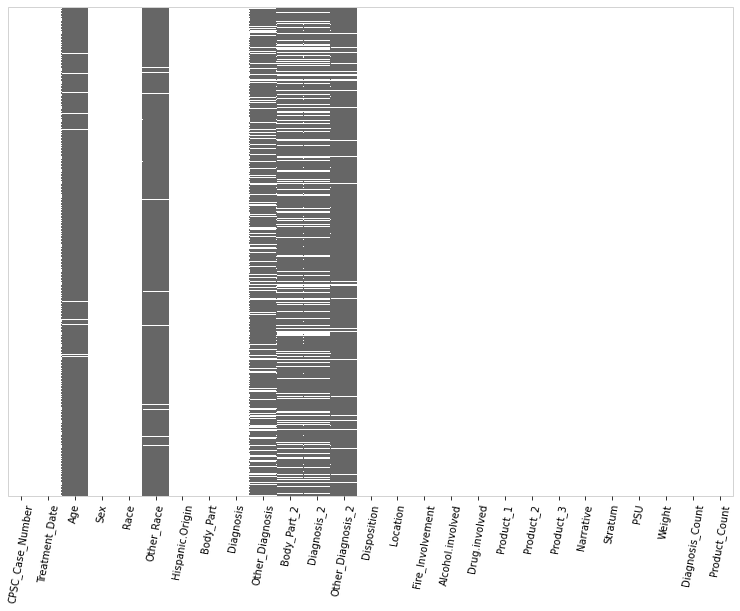

In [20]:
# given a dataframe df create a copy of the array that is 0 if a field contains a
# value and 1 for NaN
naInfo = np.zeros(df.shape)
naInfo[df.isna().values] = 1
naInfo = pd.DataFrame(naInfo, columns=df.columns)
fig, ax = plt.subplots()
fig.set_size_inches(13, 9)
ax = sns.heatmap(naInfo, vmin=0, vmax=1, cmap=["white", "#666666"], cbar=False, ax=ax)
ax.set_yticks([])

# draw frame around figure
rect = plt.Rectangle((0, 0), naInfo.shape[1], naInfo.shape[0], linewidth=1, edgecolor="lightgrey", facecolor="none")
rect = ax.add_patch(rect)
rect.set_clip_on(False)
plt.xticks(rotation=80)
plt.show()

In [21]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/41 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Preprocessing the Data

In [22]:
# Drop the top 3 features missing data - DAYO
# df.drop(columns=['B', 'C'])

# Drop the Hispanic Column Data - DAYO 

# Missing data plot for dataframe - DAYO

# Map race by encoding - DAYO

# Add column "Number of Injured body" that counts number of injuries per entry - DAYO

# Format datetime data column appropritely - RON

# Format Age data column appropriately - RON

## Descriptive Analysis
* 2 Analytical graphics each
* Wei's Advice: the more we write now, the less we will have to write later

In [ ]:
# Histogram of injuries to dates - RON
